In [310]:
import pandas as pd
import sqlalchemy as sql
import matplotlib.pyplot as plt
%matplotlib notebook

from tqdm import tqdm

# Data Dictionary

#### orders (415k rows): fact table, one record per order, includes useful time dimensions
- order_id: order identifier
- user_id: customer identifier
- order_number: the order sequence number for this user (1 = first, n = nth)
- order_dow: the day of the week the order was placed on
- Order_hour_of_day: hour of day the order was placed
- Days_since_prior_order: Number of days since that customer placed their previous order (NA for order_number = 1)

#### order_products (3.9M rows): fact table, one record per order, per product
_except for last order by a customer_
- order_id: foreign key
- product_id: foreign key
- add_to_cart_order: order in which each product was added to cart
- reordered: 1 if this product has been ordered by this user in the past, 0 otherwise

#### products (50k rows): Dimension table for product info
- product_id: product identifier
- product_name: name of the product
- aisle_id: foreign key
- department_id: foreign key

#### aisles (134 rows): Dimension table for aisle info
- aisle_id: aisle identifier
- aisle: the name of the aisle

#### departments (21 rows): Dimension table for department info
- department_id: department identifier
- department: the name of the department


In [2]:
engine = sql.create_engine('sqlite:///instacart.db')
db = {}

In [3]:
for table in ['orders', 'order_products', 'products', 'aisles', 'departments',]:
    db[table] = pd.read_sql_table(table, engine, index_col=0,)

In [4]:
# aliases
orders = db['orders']
orders.set_index('order_id', inplace=True)

ops = db['order_products']   # default index vs. multi-index on order_id + add_to_cart_order

products = db['products']
del(products['index'])       # index is one off from xxxx_id, confusing
products.set_index('product_id', inplace=True)

del(db['departments']['index'])
db['departments'].set_index('department_id', inplace=True)

del(db['aisles']['index'])
db['aisles'].set_index('aisle_id', inplace=True)

In [5]:
from collections import defaultdict

# build dictionaries mapping aisles <-> departments
depts = defaultdict(set)
aisles = {}
for aisle in db['aisles'].index:
    aisle_products = products[products.aisle_id == aisle]['department_id']
    for product_dept in aisle_products:
        depts[int(product_dept)].add(int(aisle))
        aisles[int(aisle)] = int(product_dept)

In [321]:
# enter a dept number 1-21 to get a lsit of corresponding aisles
dept_num = 1
print(db['departments'].department[dept_num] + '\n')

for aisle_num in depts[dept_num]:
    print(db['aisles'].aisle[aisle_num])

frozen

frozen appetizers sides
frozen meat seafood
ice cream ice
frozen meals
frozen vegan vegetarian
frozen pizza
frozen juice
frozen breakfast
frozen produce
frozen dessert
frozen breads doughs


In [322]:
orders.count()

user_id                   414772
order_number              414772
order_dow                 414772
order_hour_of_day         414772
days_since_prior_order    389772
order_id                  414772
dtype: int64

In [323]:
len(db['order_products']['order_id'].unique())

389772

In [324]:
orders[orders['user_id'] == 2]

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_id
order_id,,,,,,
2168274,2,1,2,11,NaN,2168274
1501582,2,2,5,10,10.0,1501582
1901567,2,3,1,10,3.0,1901567
738281,2,4,2,10,8.0,738281
1673511,2,5,3,11,8.0,1673511
1199898,2,6,2,9,13.0,1199898
3194192,2,7,2,12,14.0,3194192
788338,2,8,1,15,27.0,788338
1718559,2,9,2,9,8.0,1718559


In [325]:
db['order_products'][ops['order_id'] == 1492625]  # last order by customer no. 2

,order_id,product_id,add_to_cart_order,reordered


                 ^
## Order_products does not include the last order by any customer


# Analysis:

## Topics

Breakdowns by:

1. Product (most popular, least)
2. Departments ( -> Aisles)
3. Customers:
- best: what is predictive in first order of repeat customers
- worst: what is predictive in first order of single-visit customers
4. Timing (week, day)
5. Item order: what % of times that a product is ordered is it the first item ordered? i.e. types of items that are top-of mind
6. Products: what are predictions for next product added to cart? Could we increase sales by showing this item?


# 0. A quick look at the shape of the data

<IPython.core.display.Javascript object>


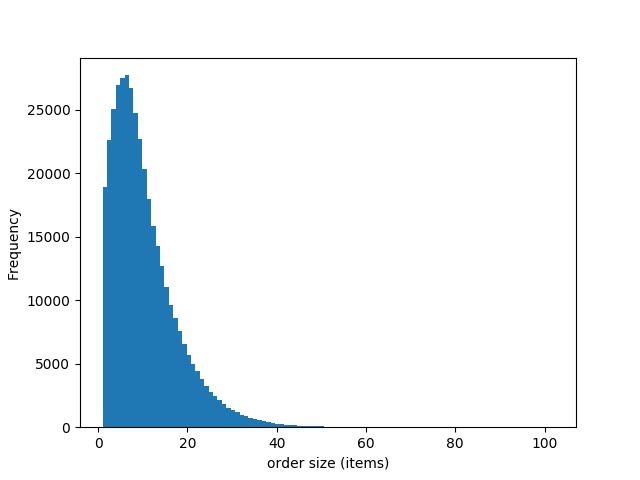

Text(0.5,0,'order size (items)')

In [326]:
ax = ops.groupby('order_id').size().plot.hist(bins=102)
ax.set_xlabel('order size (items)')

<IPython.core.display.Javascript object>


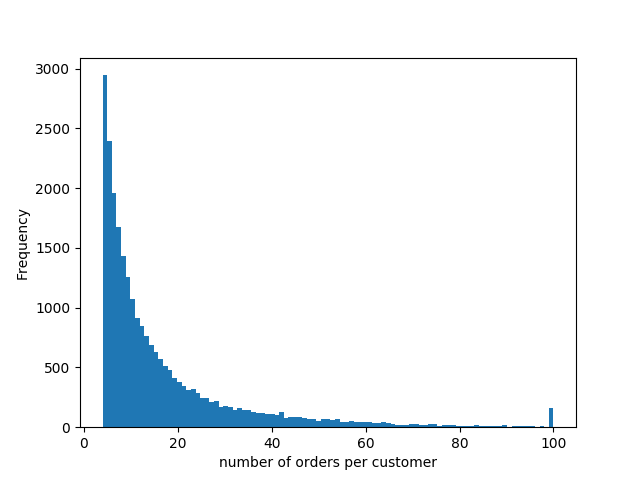

Text(0.5,0,'number of orders per customer')

In [327]:
ax = orders.groupby('user_id').size().plot.hist(bins=97)  # tail accumulates at 100
ax.set_xlabel('number of orders per customer')

In [130]:
times_product_ordered = pd.DataFrame({'times_ordered': ops.groupby('product_id').size()})

In [21]:
orders['order_id'] = orders.index
user_orders = orders.groupby('user_id')['order_id'].unique()  # DF of order_id for each user

In [152]:
times_product_ordered = times_product_ordered.join(db['products']).sort_values('times_ordered', ascending=False)

In [175]:
times_product_ordered[:20]

,times_ordered,product_name,aisle_id,department_id,log_times
product_id,,,,,
24852,58231,Banana,24,4,4.765154
13176,45699,Bag of Organic Bananas,24,4,4.659907
21137,32203,Organic Strawberries,24,4,4.507896
21903,29380,Organic Baby Spinach,123,4,4.468052
47209,25958,Organic Hass Avocado,24,4,4.414271
47766,21642,Organic Avocado,24,4,4.335297
47626,18581,Large Lemon,24,4,4.269069
26209,17399,Limes,24,4,4.240524
16797,17217,Strawberries,24,4,4.235957


In [328]:
times_product_ordered.times_ordered[:10].sum() / len(ops) # top 10 (of 50k) products % of order items

0.07206760406015819

In [329]:
times_product_ordered.times_ordered[:100].sum() / len(ops) # top 100 (of 50k) products % of order items

0.2313904318989711

In [331]:
times_product_ordered.times_ordered[:1000].sum() /len(ops) # top 1000 (of 50k) products % of order items

0.5430262797072625

In [333]:
times_product_ordered.times_ordered[:10000].sum() / len(ops) # top 10000 (of 50k) products % of order items

0.9142364470251706

In [241]:
times_product_ordered[times_product_ordered.times_ordered.isin([1, 2])].count()
# almost 20% of items have only been ordered 1 or 2 times

times_ordered    9301
product_name     9301
aisle_id         9301
department_id    9301
log_times        9301
dtype: int64

In [284]:
times_product_ordered['reorder_pct'] = ops.groupby('product_id').mean().reordered

In [419]:
plt.xlabel

'number of orders'

department    produce
Name: 4, dtype: object


<IPython.core.display.Javascript object>


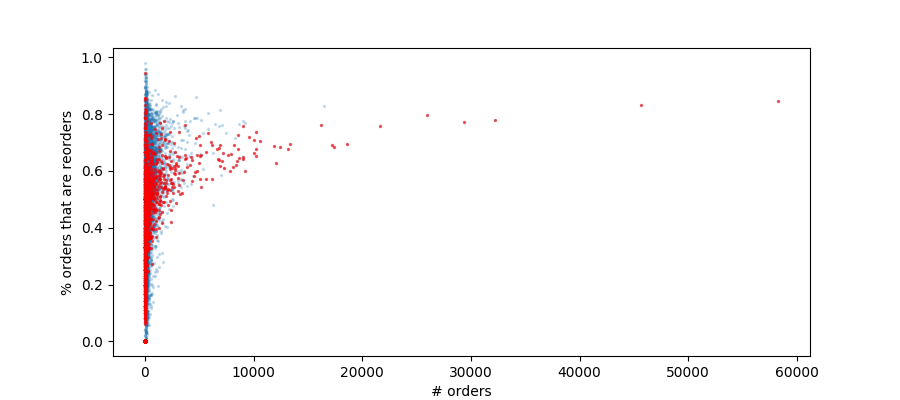

In [459]:
qty = 10000
dept_id = 4
print(db['departments'].loc[dept_id])
fig, ax = plt.subplots()
fig.set_size_inches(9,4)
ax.scatter(times_product_ordered.times_ordered[:qty], times_product_ordered.reorder_pct[:qty], s=2, alpha=.2,)
ax.scatter(times_product_ordered[times_product_ordered.department_id == dept_id].times_ordered[:qty], 
           times_product_ordered[times_product_ordered.department_id == dept_id].reorder_pct[:qty], s=2, alpha=.5, color='red')
ax.set_xlabel('# orders')
ax.set_ylabel('% orders that are reorders')
plt.show()
# what is the outlier below mass of data points? x ~= 6300

In [301]:
times_product_ordered[times_product_ordered.times_ordered < 6500][:10]    # outlier is olive oil; seems ok

,times_ordered,product_name,aisle_id,department_id,log_times,reorder_pct
product_id,,,,,,
24838,6418,Unsweetened Almondmilk,91,16,3.807400,0.764101
25890,6236,Boneless Skinless Chicken Breasts,49,12,3.794906,0.662765
31506,6230,Extra Virgin Olive Oil,19,13,3.794488,0.480738
46667,6218,Organic Ginger Root,83,4,3.793651,0.570601
22825,6199,Organic D'Anjou Pears,24,4,3.792322,0.690595
39928,6044,Organic Kiwi,24,4,3.781324,0.703342
35221,5803,Lime Sparkling Water,115,7,3.763653,0.748578
12341,5796,Hass Avocados,32,4,3.763128,0.734990
5785,5777,Organic Reduced Fat 2% Milk,84,16,3.761702,0.805262


In [364]:
times_product_ordered[times_product_ordered.product_name.str.lower().str.contains('olive oil')][:20]

,times_ordered,product_name,aisle_id,department_id,log_times,reorder_pct,num_reorders
product_id,,,,,,,
31506,6230,Extra Virgin Olive Oil,19,13,3.794488,0.480738,2995.0
21195,1632,Organic Extra Virgin Olive Oil,19,13,3.212720,0.521446,851.0
10644,1515,Italian Extra Virgin Olive Oil,19,13,3.180413,0.388779,589.0
33438,418,Rosemary & Olive Oil Quinoa Blend,63,9,2.621176,0.327751,137.0
48192,342,Butter with Olive Oil & Sea Salt,36,16,2.534026,0.587719,201.0
34619,296,Triscuit Baked Whole Grain Wheat Rosemary & Ol...,78,19,2.471292,0.500000,148.0
40724,295,Soy Free Buttery Spread with Olive Oil,91,16,2.469822,0.572881,169.0
32463,293,Olive Oil & Aloe Vera Hand Soap,25,11,2.466868,0.368601,108.0
29195,283,Wild Sardines in Extra Virgin Olive Oil,95,15,2.451786,0.544170,154.0


In [344]:
times_product_ordered['num_reorders'] = times_product_ordered.times_ordered * times_product_ordered.reorder_pct

In [367]:
aisle_reorders = times_product_ordered.groupby('aisle_id').sum().join(db['aisles'])[['times_ordered', 'num_reorders', 'aisle']].sort_values('times_ordered', ascending=False)
aisle_reorders['pct_reorders'] = aisle_reorders.num_reorders / aisle_reorders.times_ordered
aisle_reorders['dept'] = aisle_reorders.index
aisle_reorders['dept'] = aisle_reorders.dept.apply(lambda x: aisles[x])
aisle_reorders.sort_values('pct_reorders')[:20]  # personal care products are a potential opportunity for reorders

,times_ordered,num_reorders,aisle,pct_reorders,dept
aisle_id,,,,,
104,25295,3800.0,spices seasonings,0.150227,13
118,1261,207.0,first aid,0.164155,11
97,2806,494.0,baking supplies decor,0.176051,13
44,1046,202.0,eye ear care,0.193117,11
10,1120,231.0,kitchen supplies,0.206250,17
87,2070,456.0,more household,0.220290,17
109,1208,267.0,skin care,0.221026,11
11,3078,696.0,cold flu allergy,0.226121,11
55,1283,305.0,shave needs,0.237724,11


In [268]:
dept_orders = pd.DataFrame({'times_ordered': times_product_ordered.groupby('department_id').times_ordered.sum()}).join(db['departments']).sort_values('times_ordered', ascending=False)

<IPython.core.display.Javascript object>


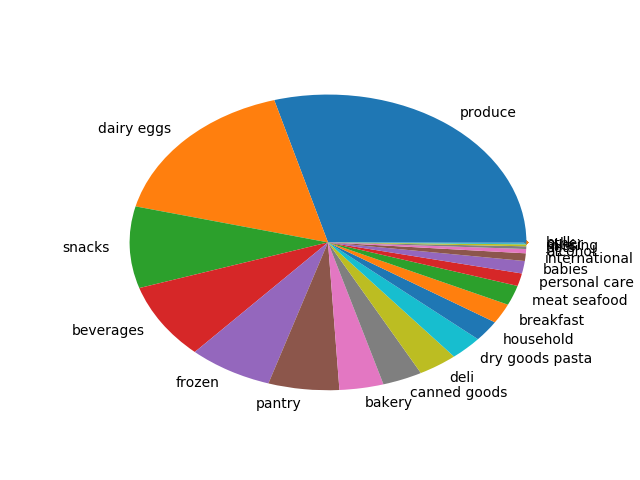

Text(0,0.5,'')

In [405]:
ax = dept_orders.plot.pie(y='times_ordered', labels=dept_orders.department, legend=False)
ax.set_ylabel('')

In [75]:
user_means = {}
user_std = {}
order_sizes = ops.groupby('order_id').size()

# plot number of orders by user vs. average size of those orders
for i in tqdm(range(len(user_orders))):
    row = user_orders.iloc[i]   # row is list of orders a user has made
    user = user_orders.index[i]
    order_sizes_for_user = []
    for order in row:
        # print(order)
        try:
            order_sizes_for_user.append(order_sizes[order])
        except KeyError:
            continue
    user_means[user] = pd.np.mean(order_sizes_for_user)
    user_std[user] = pd.np.std(order_sizes_for_user)

100%|██████████| 25000/25000 [00:10<00:00, 2416.02it/s]


In [69]:
user_orders[2]

array([2168274, 1501582, 1901567,  738281, 1673511, 1199898, 3194192,
        788338, 1718559, 1447487, 1402090, 3186735, 3268552,  839880,
       1492625])

In [103]:
users = orders.groupby('user_id').size()

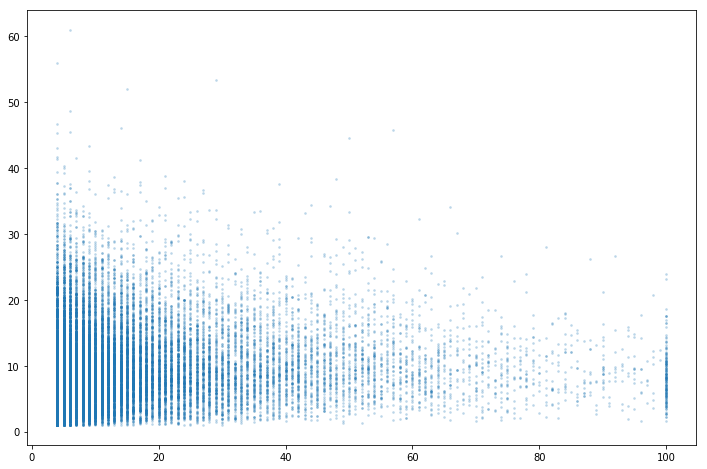

In [222]:
plt.figure(figsize=(12,8))
ax = plt.scatter(x=users, y=user_mean, s=3, alpha=.2)
ax.set_label('users')

Text(0.5,0,'Day of week')

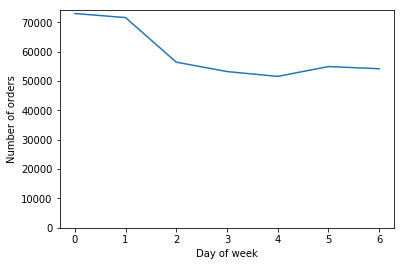

In [117]:
ax = orders.groupby('order_dow').size().plot()
ax.set_ybound(0)
ax.set_ylabel('Number of orders')
ax.set_xlabel('Day of week')

[Text(0,0,'0'),
 Text(0,0,'1'),
 Text(0,0,'2'),
 Text(0,0,'3'),
 Text(0,0,'4'),
 Text(0,0,'5'),
 Text(0,0,'6'),
 Text(0,0,'7')]

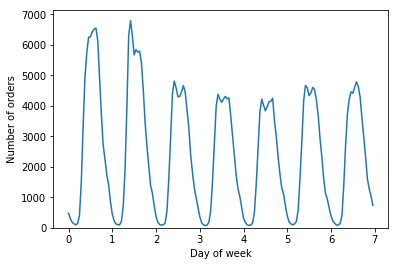

In [119]:
ax = orders.groupby(['order_dow', 'order_hour_of_day']).size().plot()
ax.set_ybound(0)
ax.set_ylabel('Number of orders')
ax.set_xlabel('Day of week')
ax.set_xticks([24 * i for i in range(8)])
ax.set_xticklabels(range(8))

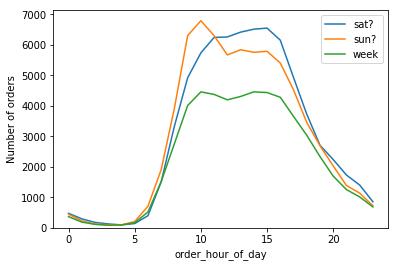

In [120]:

ax = (orders[orders.order_dow == 0].groupby('order_hour_of_day').size()).plot(label='sat?')
ax = (orders[orders.order_dow == 1].groupby('order_hour_of_day').size()).plot(label='sun?')
ax.set_ylabel('Number of orders')
ax.set_xlabel('hour')

ax = (orders[orders.order_dow.isin([2,3,4,5,6])].groupby('order_hour_of_day').size()/5).plot(label='week')
ax.set_ybound(0)
ax.legend()

# Interesting features of time distribution: 

- weekday lunch trough
- first two days must be Sat/Sun? 5 vs. 2

In [ ]:
ops